<p>Created by:
<ul>
  <li> CHIBI Saad </li>
  <li> DAHMOU Hicham</li>
  <li> JOUDARI Ala eddine</li>
</ul>
</p>
<p >School: IMT Mines Ales</p>
<p >Academic year: 2020-2021</p>
<p >Supervised by: Sébastien Harispe</p>

<h1><center>Machine learning project <br/> Predicting Memes posts scores on Reddit</center></h1>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast, warnings
from collections import Counter

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge , BayesianRidge
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold,GridSearchCV

warnings.filterwarnings('ignore') #Just to remove warning about pandas assignment operations

# Defining our task

Predicting popularity of posts in social media networks is an interesting task: could be used for more targeted advertising, content filtering (ex: easier content moderation), understanding population general opinion or just improving one's own reputation  (what are the criterias that I must take into account to maximise the number of likes on my new picture in the bahamas).

As a platform of tests we chose Reddit: a social news aggregation, web content rating, and discussion website where members submit content to the site such as links, text posts, and images, which are then voted up or down by other members. Posts are organized by subject into user-created boards called "communities" or "subreddits", which cover a variety of topics such as news, politics, science, memes, music... [source : Wikipedia]

In this work we limit ourselves to the topic of memes: popular, well-known and has a dataset ready to use, so the task is to train a memes scores predictor on a specific subreddit and test it on a second one to estimate the possibility of generalization.


# Dataset Description and Preprocessing

## Fetching and description

For the dataset, we choose the cleaned version in the following git repository:  https://github.com/dimaTrinh/dank_data [accessed 26 Feb, 2021] (that you also will find attached to this notebook).


In [ ]:
url = 'https://raw.githubusercontent.com/TiernonRR/Dank_AIT/master/Data/final_dank.csv'
reddit_memes_postes = pd.read_csv(url)

It was created first by using the psaw: https://github.com/dmarx/psaw [accessed 26 Feb, 2021]API to fetch reddits posts info (of course from a defined set of subreddits and time intervale) and then clean it by removing the posts for which the URL is not responding at the time of the dataset creation.

Which give us:

In [ ]:
reddit_memes_postes.head(3)

,Unnamed: 0,level_0,index,author,awards,processed_words,created_utc,downs,id,is_nsfw,media,subreddit,subscribers,thumbnail.height,thumbnail.thumbnail,thumbnail.width,title,ups,url,datetime_temp,time_of_day,ups_normed,dank_level,TextLength,Sentiment,word_count,avg_blueRGB,avg_greenRGB,avg_hue,avg_redRGB,avg_saturation,avg_value,off-white,aqua,mustard,pure-black,purple,red-brown,dust-brown,gray-blue,orange,salmon,dark-green,pink,pure-white,yellow-green,bright-yellow,teal,cyan,gray,maroon,olive,light-blue,plum,siena-brown,gold,pure-red,pure-green,pure-blue,coral,peach,col,vgg1_prob,vgg2_prob,vgg3_prob,vgg_feature_1,vgg_feature_2,vgg_feature_3
0,1,1.0,1.0,MrManic_BipolarJesus,[],"['sometimesth', 'face', 'go', 'work', 'get', '...",1.584487e+09,0.0,fkf6kd,False,https://i.redd.it/hvwi2hi0fbn41.jpg,r/dank_meme,743610.0,140.0,default,140.0,It just be that way sometimes,1.0,/r/dank_meme/comments/fkf6kd/it_just_be_that_w...,2020-03-17 18:12:42,4.0,0.000001,0.0,118.0,0.58,8.0,147.757079,168.175000,62.086751,117.246365,114.450720,180.432838,0.211911,0.0,26.840028,8.546572,0.0,0.000000,0.707306,0.000000,0.0,2.943594,0.000104,0.0,0.0,0.011115,0.0,0.000000,0.0,0.611011,0.000000,0.0,0.112708,0.0,0.0,2.197957,0.0,0.0,0.0,0.0,2.943594,0.013296,0.111413,0.075089,0.052672,binder,envelope,web_site
1,3,3.0,3.0,andromedacomp,[],"['time', 'come', 'barter', 'pandem', 'day', 'r...",1.584487e+09,0.0,fkf5n5,False,https://i.redd.it/ndydkhwsman41.jpg,r/dank_meme,743610.0,140.0,https://b.thumbs.redditmedia.com/EzbMKRx8VI20u...,140.0,The time has come for the barter of pandemic d...,27.0,/r/dank_meme/comments/fkf5n5/the_time_has_come...,2020-03-17 18:11:06,4.0,0.000036,0.0,93.0,0.29,8.0,119.370886,129.343111,26.929992,147.671462,60.363362,148.270765,1.511079,0.0,0.001508,4.359288,0.0,0.021108,0.484721,0.077646,0.0,0.059742,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,9.953184,0.000377,0.0,0.000000,0.0,0.0,0.036184,0.0,0.0,0.0,0.0,0.059742,0.997712,0.882181,0.059749,0.038527,neck_brace,oxygen_mask,gasmask
2,4,4.0,4.0,Svagerman,[],"['gang', 'derin', 'mlke', 'wey', 'stealin', 's...",1.584486e+09,0.0,fkezoq,False,https://i.redd.it/43710pqzcbn41.jpg,r/dank_meme,743610.0,134.0,default,140.0,Day 10 of quarantine,1.0,/r/dank_meme/comments/fkezoq/day_10_of_quarant...,2020-03-17 18:00:44,4.0,0.000001,0.0,114.0,0.43,8.0,228.477731,227.718832,24.516272,230.144539,7.356443,231.347965,4.552819,0.0,0.000000,3.422582,0.0,0.017642,0.010244,0.293657,0.0,1.318610,0.000000,0.0,0.0,0.000000,0.0,0.010813,0.0,5.226068,0.009675,0.0,0.000000,0.0,0.0,0.001138,0.0,0.0,0.0,0.0,1.318610,0.537233,0.296721,0.237206,0.112602,envelope,comic_book,web_site


As for the meaning of each column, we were lucky enough to find the description of the columns at the repo readme and original paper: "Dank or Not? -- Analyzing and Predicting the Popularity of Memes on Reddit".

(Unnamed: 0 and level_0 are artifacts that we will remove in a few lines).


| Feature | Type | Description |
|----------------------|-------------------------------|--------------------------------------------------------|
| created_utc | UTC timestamp | time of post submission |
| ups | integer | number of upvotes received |
| is_nsfw | boolean | indicates if only suitable for 18\+ |
| subreddit | string | subreddit of the submission |
| subscribers | integer | number of subscribers to the subreddit |
| thumbnail\.height | floating point value | height of the thumbnail |
| thumbnail\.thumbnail | string | thumbnail media |
| thumbnail\.width | floating point value | width of thumbnail |
| title | string | title of the submission |
| media | string | link to associated meme media |
| ups_normed | floating point value | ups normalized with subscribers |
| dank_level | integer | label ups_normed for binary classification |
| processed_words | list of strings | filtered and stemmed words from title and image |
| word_count | integer | number of words in title and image |
| TextLength | integer | number of characters in title |
| Sentiment | floating point value | text valence score |
| avg_hue | floating point value | average HSV hue value of meme |
| avg_saturation | floating point value | average HSV saturation value of meme |
| avg_value | floating point value | average HSV value value of meme |
| 30 colors | floating point value | normalized pixels of color in image |
| VGG_features | list of strings | VGG\-16's first three guesses about image content |
| VGG_probs | list of floating point values | the probabilities of the VGG\-16's first three guesses |

### Which subreddits and at what time

the subreddits that we targeted are :

In [ ]:
print(reddit_memes_postes["subreddit"].unique())

['r/dank_meme' 'r/dankmeme' 'r/me_irl' 'r/MemeEconomy' 'r/memes' nan]


all of them are memes communities, also we are reminded that some missing data is lurking and waiting to cause problems (we will deal with it in a few lines)

As for the time segment for which this data correspond:

In [ ]:
from datetime import datetime

created_utc_min = datetime.utcfromtimestamp(reddit_memes_postes["created_utc"].min()).strftime('%Y-%m-%d %H:%M:%S')
created_utc_max = datetime.utcfromtimestamp(reddit_memes_postes["created_utc"].max()).strftime('%Y-%m-%d %H:%M:%S')
print("from:", created_utc_min)
print("to:", created_utc_max)

from: 2020-03-13 23:17:47
to: 2020-03-23 04:59:45


which corresponds to:

(https://www.researchgate.net/figure/Timeline-showing-the-most-important-events-occurred-in-the-world-from-novel-coronavirus_fig2_342840258 [accessed 26 Feb, 2021])

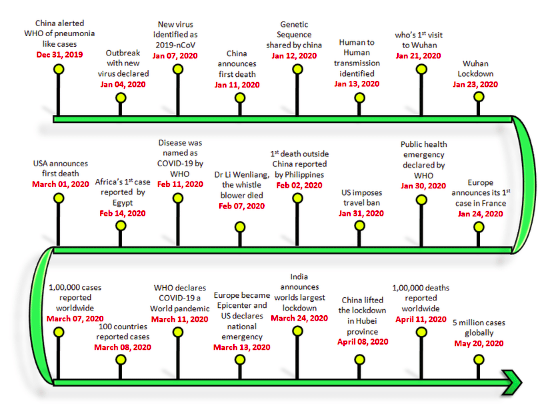

### Can we let go of some columns/rows? (even that we just started)

For the columns yes, for the rows no.





As a start, we could let go of:
* *Unnamed: 0* and *level_0*  (just artifacts while importing the dataset)
* We don't see any value in keeping a zeros column: *downs* 
* *id*, *author* and *media* that don't add any info (at least without being used to get external data)
* *thumbnail.thumbnail* because all links are broken (it is just a resized version of the original image)

In [ ]:
reddit_memes_postes.drop(columns=["Unnamed: 0", "index", "level_0", "downs", "id", "author", "media", "thumbnail.thumbnail"],inplace=True)
reddit_memes_postes.reset_index(drop=True, inplace=True)

*leaving* use with

In [ ]:
print(reddit_memes_postes.columns)

Index(['awards', 'processed_words', 'created_utc', 'is_nsfw', 'subreddit',
       'subscribers', 'thumbnail.height', 'thumbnail.width', 'title', 'ups',
       'url', 'datetime_temp', 'time_of_day', 'ups_normed', 'dank_level',
       'TextLength', 'Sentiment', 'word_count', 'avg_blueRGB', 'avg_greenRGB',
       'avg_hue', 'avg_redRGB', 'avg_saturation', 'avg_value', 'off-white',
       'aqua', 'mustard', 'pure-black', 'purple', 'red-brown', 'dust-brown',
       'gray-blue', 'orange', 'salmon', 'dark-green', 'pink', 'pure-white',
       'yellow-green', 'bright-yellow', 'teal', 'cyan', 'gray', 'maroon',
       'olive', 'light-blue', 'plum', 'siena-brown', 'gold', 'pure-red',
       'pure-green', 'pure-blue', 'coral', 'peach', 'col', 'vgg1_prob',
       'vgg2_prob', 'vgg3_prob', 'vgg_feature_1', 'vgg_feature_2',
       'vgg_feature_3'],
      dtype='object')


As for the rows, it is better to wait until we choose the features to keep before dropping the rows with a nan value (to avoid dropping a row because of a value that we don't even care about).

## Variables description

In [ ]:
reddit_memes_postes.describe()

,created_utc,subscribers,thumbnail.height,thumbnail.width,ups,time_of_day,ups_normed,dank_level,TextLength,Sentiment,word_count,avg_blueRGB,avg_greenRGB,avg_hue,avg_redRGB,avg_saturation,avg_value,off-white,aqua,mustard,pure-black,purple,red-brown,dust-brown,gray-blue,orange,salmon,dark-green,pink,pure-white,yellow-green,bright-yellow,teal,cyan,gray,maroon,olive,light-blue,plum,siena-brown,gold,pure-red,pure-green,pure-blue,coral,peach,col,vgg1_prob,vgg2_prob,vgg3_prob
count,6.994200e+04,6.994200e+04,69902.000000,69902.000000,69942.000000,69942.000000,6.994200e+04,69942.000000,69942.000000,69942.000000,69942.000000,50651.000000,50651.000000,50651.000000,50651.000000,50651.000000,50651.000000,50538.000000,50538.000000,50538.000000,50538.000000,50538.0,50538.000000,50538.000000,50538.000000,50538.000000,50538.000000,50538.000000,50538.0,50538.0,50538.000000,50538.000000,50538.000000,50538.000000,50538.000000,50538.000000,50538.0,50538.000000,50538.0,50538.0,50538.000000,50538.000000,50538.000000,50538.000000,50538.0,50538.000000,50538.000000,43722.000000,4.372200e+04,4.372200e+04
mean,1.584477e+09,9.207741e+06,125.177248,139.987983,541.237125,2.509351,6.734436e-05,0.049327,125.687641,0.435738,9.531026,128.639556,133.423249,46.300384,140.567151,65.437999,150.060820,4.798367,0.153165,0.167914,16.674078,0.0,2.044136,1.809780,0.583991,0.909801,1.834024,0.500861,0.0,0.0,0.058077,0.046286,0.473762,0.156010,3.638643,0.916173,0.0,0.094840,0.0,0.0,3.750098,0.055067,0.475572,0.109823,0.0,1.834024,2.522078,0.417049,1.000319e-01,5.451307e-02
std,2.405481e+05,2.340807e+06,21.904673,0.917085,4064.362588,1.642883,6.281470e-04,0.216551,121.264094,0.105836,9.133303,50.418799,49.587056,28.166636,49.936033,38.960155,48.927037,11.777363,2.312782,2.428924,35.540049,0.0,6.211629,5.825221,2.074496,5.528671,7.295825,3.707556,0.0,0.0,1.026982,1.817635,3.120145,2.937522,8.418674,4.200325,0.0,1.811116,0.0,0.0,9.429906,2.321886,4.390867,2.114918,0.0,7.295825,8.577559,0.283978,7.352966e-02,3.798340e-02
min,1.584141e+09,4.550600e+04,9.000000,70.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.016944,4.700000e-09,2.900000e-09
25%,1.584285e+09,9.552833e+06,113.000000,140.000000,3.000000,1.000000,3.747367e-07,0.000000,66.000000,0.400000,5.000000,93.589513,100.048523,24.389515,107.510989,37.174465,117.865021,0.463955,0.000000,0.000000,1.284356,0.0,0.000000,0.001553,0.001221,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.707092,0.000000,0.0,0.000000,0.0,0.0,0.001864,0.000000,0.000000,0.000000,0.0,0.000000,0.003986,0.178647,4.770961e-02,2.668579e-02
50%,1.584416e+09,9.552918e+06,140.000000,140.000000,22.000000,3.000000,2.450729e-06,0.000000,100.000000,0.450000,8.000000,126.528284,132.802437,42.309425,141.884962,60.765319,152.472961,1.573736,0.000000,0.000000,4.341714,0.0,0.087599,0.127748,0.049178,0.000000,0.008263,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.652294,0.001946,0.0,0.000000,0.0,0.0,0.319410,0.000000,0.000000,0.000000,0.0,0.008263,0.201326,0.333129,8.447164e-02,4.898013e-02
75%,1.584593e+09,1.067420e+07,140.000000,140.000000,39.000000,4.000000,4.215734e-06,0.000000,146.000000,0.500000,11.000000,162.083398,167.005624,64.330374,174.196552,89.668617,184.591979,4.369115,0.000000,0.000000,11.297761,0.0,1.165920,1.006928,0.366696,0.000467,0.509722,0.001853,0.0,0.0,0.000000,0.000000,0.005471,0.000000,3.630198,0.150007,0.0,0.000000,0.0,0.0,2.920194,0.000000,0.000000,0.000000,0.0,0.509722,1.466760,0.632396,1.369548e-01,7.537094e-02
max,1.584940e+09,1.067438e+07,140.000000,140.000000,197317.000000,5.000000,7.238046e-02,1.000000,6862.000000,0.840000,482.000000,255.000000,255.000000,175.696601,255.000000,255.000000,25

In this section, we loop through all the variables and discuss each one apart 

### Awards

For some strange reason it isn't on the given description so must inspect it ourselves.

At first glance it may seem that it is always empty (like the *downs* column that we removed):

In [ ]:
((reddit_memes_postes["awards"].notnull()) & (reddit_memes_postes["awards"] != '[]')).value_counts()

False    75219
True       919
Name: awards, dtype: int64

In [ ]:
print("There are "+str(round(919/len(reddit_memes_postes)*100,2))+"% non empty values for the column awards.")

There are 1.21% non empty values for the column awards.


Examples of values:

In [ ]:
reddit_memes_postes["awards"].value_counts()

[]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

Having been on Reddit for some years, I recognize this table, it represents the list of awards given by Redditors to the post owner, there are different categories each with its value and icon (they cost money that's why you don't see much of them).

In our use case, this column can't be used in any form considering that the poster can't adapt this parameter (at least in a simple form, I mean you could always use other accounts to *reward* yourself which could influence the visitors to value higher your post but this is outside of the scope of the project)

### processed_words

"filtered and stemmed words from title and image"

Let's see what are the most frequente words:

We have 80325 unique tokens.
The 20 tokens represente 12.94 % of the values.


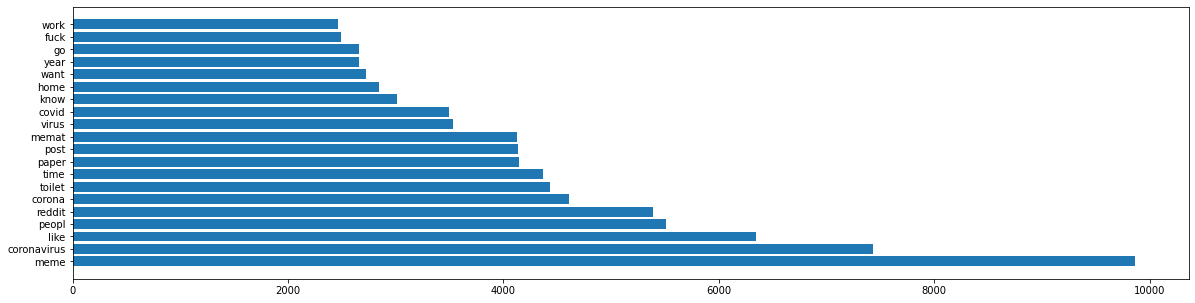

In [ ]:
pool_words = []
for element in reddit_memes_postes["processed_words"]:
  try:
    pool_words.extend(ast.literal_eval(element))
  except:
      continue

n = 20
b_pool_words = Counter(pool_words)
keys, values = [element[0] for element in b_pool_words.most_common(n)], [element[1] for element in b_pool_words.most_common(n)]

plt.figure(figsize=(20,5))
plt.barh(keys, values)

print("We have", str(len(np.unique(pool_words))), "unique tokens.")
print("The", str(n), "tokens represente", str(round(sum(values)/len(pool_words)*100,2)), '% of the values.')

### Time

The categories need some cleaning before being used in a meaningful way:
*   assemble synonyms, ex: corona+covid+coronavirus must be made into one category (making the most frequent token).
*   Reduce the number of categories by clustering them into meaningful groups after using NLP methods.



#### created_utc

created_utc: "utc timestamp of post submission"



As already showen:

In [ ]:
from datetime import datetime

created_utc_min = datetime.utcfromtimestamp(reddit_memes_postes["created_utc"].min()).strftime('%Y-%m-%d %H:%M:%S')
created_utc_max = datetime.utcfromtimestamp(reddit_memes_postes["created_utc"].max()).strftime('%Y-%m-%d %H:%M:%S')
print("from:", created_utc_min)
print("to:", created_utc_max)

from: 2020-03-13 23:17:47
to: 2020-03-23 04:59:45


considering the data was scraped in about 20 days, the influence of the evolution of the number of community subscribers by time is minimal.
This is why we will discard it 

#### time_of_day

time_of_day: discretized time of day in 4 hour increments [0-4, 5-8, 9-12, 13-16, 17-20, 21-24]

the hour part is better captured by the *time_of_day* variable (it is more robust).



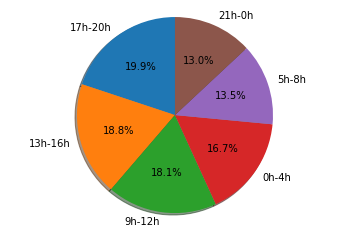

In [ ]:
reddit_memes_postes.loc[:,'time_of_day'] = reddit_memes_postes['time_of_day'].astype("str")
reddit_memes_postes['time_of_day'] = reddit_memes_postes['time_of_day'].replace(['nan'], np.nan)

time_of_day = {
    "0.0":"0h-4h",
    "1.0":"5h-8h",
    "2.0":"9h-12h",
    "3.0":"13h-16h",
    "4.0":"17h-20h",
    "5.0":"21h-0h"
}
x = [time_of_day[value] for value in reddit_memes_postes["time_of_day"].value_counts().index.values] 
y = list(reddit_memes_postes["time_of_day"].value_counts())

fig1, ax1 = plt.subplots()
ax1.pie(y, labels=x, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  
plt.show()

#### datetime_temp

As for the day in which it was posted it may seem interesting to extract it, but don't forget that we have at best 3 values for the same day of the week to be able to generalize or get any insight, so we think that the variable *created_utc* is not meaningful enough to stay.

It is an alternative representation for the created_utc, more readable for the user but less for the computer which is why we will discard it.

In [ ]:
reddit_memes_postes["datetime_temp"].head()

0    2020-03-17 18:12:42
1    2020-03-17 18:11:06
2    2020-03-17 18:00:44
3    2020-03-17 17:36:24
4    2020-03-17 17:31:35
Name: datetime_temp, dtype: object

### is_nsfw

"indicates if only suitable for 18+"

We expect that there are fewer NSFW posts 

(for non-redditors NSFW stands for Not Safe For Work, content of posts in this category is by default hidden)

In [ ]:
reddit_memes_postes["is_nsfw"].value_counts()

False    69709
True       233
Name: is_nsfw, dtype: int64

### subreddit and subscribers

This are the subreddits that we are studying:

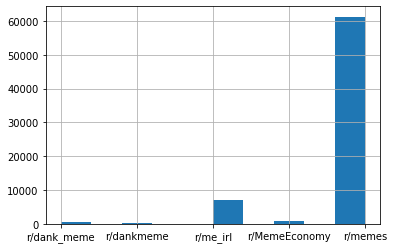

In [ ]:
reddit_memes_postes["subreddit"].hist()

As you can deduce from the figure, not all subreddits are represented in the same way which might cause problems later, so a good idea is to stick with the highest represented on 

as for the number of subscribers by subreddit:

<BarContainer object of 5 artists>

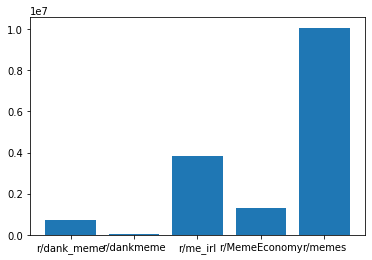

In [ ]:
subreddits = reddit_memes_postes["subreddit"].unique()
values = [np.mean(reddit_memes_postes[reddit_memes_postes["subreddit"] == subreddit]["subscribers"]) for subreddit in subreddits]
plt.bar(subreddits[:-1], values[:-1])

### thumbnail.height and thumbnail.width

As the name suggest they represent the width and height of the thumbnails:

#### thumbnail height

In [ ]:
print("thumbnail height:")
print(reddit_memes_postes["thumbnail.height"].describe())

thumbnail height:
count    69902.000000
mean       125.177248
std         21.904673
min          9.000000
25%        113.000000
50%        140.000000
75%        140.000000
max        140.000000
Name: thumbnail.height, dtype: float64


it seems that the majority of posts have 140 as a height, wich is normal, reddit postes have a fixed areas for the thumbnails, if the height of the image is greater than this given one it is just cropped

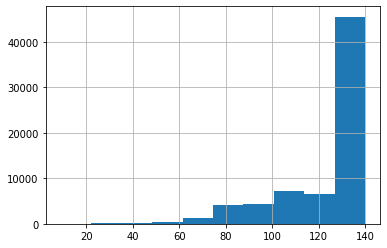

In [ ]:
reddit_memes_postes["thumbnail.height"].hist()

In [ ]:
print("the images with 140px in height represent", str(round(reddit_memes_postes["thumbnail.height"].value_counts()[140]/len(reddit_memes_postes["thumbnail.height"])*100,2)), '% of the values.')


the images with 140px in height represent 48.83 % of the values.


#### thumbnail width:

The same goes for the width.

In [ ]:
print("thumbnail width:")
print(reddit_memes_postes["thumbnail.width"].describe())

thumbnail width:
count    69902.000000
mean       139.987983
std          0.917085
min         70.000000
25%        140.000000
50%        140.000000
75%        140.000000
max        140.000000
Name: thumbnail.width, dtype: float64


In [ ]:
reddit_memes_postes["thumbnail.width"].value_counts()

140.0    69890
70.0        12
Name: thumbnail.width, dtype: int64

The majority of posts have a 140 thumbnail width, therefore it won't add any predictive value.




### title

it is already apparent from the *title* it represents the *title* of the post.

In [ ]:
reddit_memes_postes["title"].head()

0                        It just be that way sometimes
1    The time has come for the barter of pandemic d...
2                                 Day 10 of quarantine
3                 Desperate times, Desperate solutions
4                 Desperate times, Desperate solutions
Name: title, dtype: object

To use it in any meaningful way it must go through an NLP pipeline, which is already done by the team that prepared the dataset, and considering that we don't plan on expanding more on it (at least for the current task) we don't see any value in keeping it.

### ups and ups_normed

ups: "number of upvotes received"

it is our target, the variable that we want to predict

In [ ]:
reddit_memes_postes["ups"].describe()

count     69942.000000
mean        541.237125
std        4064.362588
min           0.000000
25%           3.000000
50%          22.000000
75%          39.000000
max      197317.000000
Name: ups, dtype: float64

As it seems apparent the majority of posts are getting less than 3 upvotes (low effort/creativity posts) on the other and others get hundreds of thousands of upvotes (which is normal considering that Reddit algorithm encourage hight rising posts by keeping them on the front page of the community or even at the home page of the website itself)

Bad news: The distribution of values of the target variable is bad: the majority being low effort posts.

As for the ups_normed its the number of upvotes divided by the number of subscribers in the subreddit, it cancels the hidden parameters of the social exposure (statistically speaking the more members in a community the more members will find a post funny the more upvotes it will have), this relation will be tested later when we calculate the covariance between the two variables.

### url

the url of the post

In [ ]:
reddit_memes_postes["url"].head(3)

0    /r/dank_meme/comments/fkf6kd/it_just_be_that_w...
1    /r/dank_meme/comments/fkf5n5/the_time_has_come...
2    /r/dank_meme/comments/fkezoq/day_10_of_quarant...
Name: url, dtype: object

url = "https://www.reddit.com" + subreddit + "/" + id

---



We already dropped the id, but as you might remark we didn't explain why, the time has come: 

the id/URL could be used in combination with external scrapers to fetch new features for the rows that we already have.

But in doing soo you are limited:
* for the dank_meme subreddit you are very restricted because it's a private community)
* Many posts we deleted (directly after being posted which explain partially why we have many 1 vote posted or the hosting server for the image is down)

Re-scraping the website or using external APIs is more efficient than going with this option therefore we prefer to just drop it later.

In [ ]:
"https://www.reddit.com" + reddit_memes_postes["url"][777]

'https://www.reddit.com/r/me_irl/comments/fkenll/me_irl/'

### dank_level

"Using the the normalized upvotes feature as our criteria, any posts with a normalized upvotes value in the top 5% of all posts was classified as dank (positive, 1), and the rest was classified as not dank (negative, 0). "

In [ ]:
reddit_memes_postes["dank_level"].describe()

count    69942.000000
mean         0.049327
std          0.216551
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: dank_level, dtype: float64

First, let's make it into a categorical variable

In [ ]:
reddit_memes_postes.loc[:,'dank_level'] = reddit_memes_postes['dank_level'].astype("str")
reddit_memes_postes['dank_level'] = reddit_memes_postes['dank_level'].replace(['nan'], np.nan)

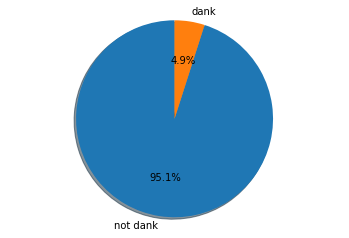

In [ ]:
x = ["not dank", "dank"]
y = (reddit_memes_postes["dank_level"].value_counts().values/len(reddit_memes_postes["dank_level"])*100).round(2)

fig1, ax1 = plt.subplots()
ax1.pie(y, labels=x, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

which makes sense taking into account the comments on the number of upvotes.

In [ ]:
(reddit_memes_postes["dank_level"].value_counts().values/len(reddit_memes_postes["dank_level"])*100).round(2)

array([87.33,  4.53])

### Sentiment

"the sentiment scores ... quantify the feeling or tone of the text. If the text is positive or happy, it scores closer to 1, and negative or sad texts score closer to 0."

In [ ]:
reddit_memes_postes["Sentiment"].describe()

count    69942.000000
mean         0.435738
std          0.105836
min          0.020000
25%          0.400000
50%          0.450000
75%          0.500000
max          0.840000
Name: Sentiment, dtype: float64

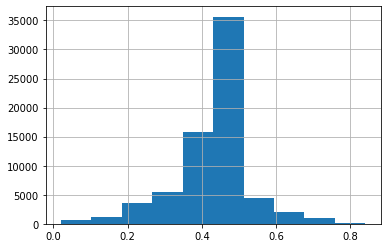

In [ ]:
reddit_memes_postes["Sentiment"].hist()

The majority of posts are close to the 0.5 point (neutral) with a higher number on the left than the right (better sad than happy).

### TextLength and word_count

#### TextLength

TextLength: "number of characters in title"

In [ ]:
reddit_memes_postes["TextLength"].describe()

count    69942.000000
mean       125.687641
std        121.264094
min          1.000000
25%         66.000000
50%        100.000000
75%        146.000000
max       6862.000000
Name: TextLength, dtype: float64

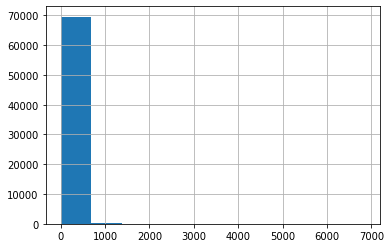

In [ ]:

reddit_memes_postes["TextLength"].hist()

After discarding the outliers we get a nicer distribution:

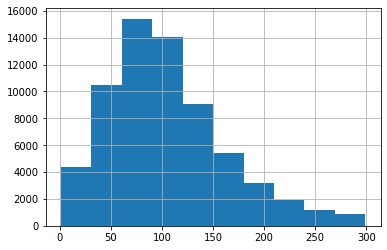

In [ ]:
reddit_memes_postes["TextLength"][reddit_memes_postes["TextLength"]<300].hist()

"Shorter is Better"

#### word_count

word_count: "number of words in title and image"

In [ ]:
reddit_memes_postes["word_count"].describe()

count    69942.000000
mean         9.531026
std          9.133303
min          0.000000
25%          5.000000
50%          8.000000
75%         11.000000
max        482.000000
Name: word_count, dtype: float64

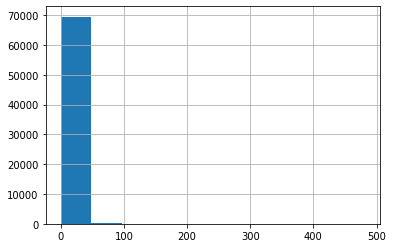

In [ ]:
reddit_memes_postes["word_count"].hist()

seems the same problem recurred (which is normal: if you have a high number of characters then likely you have a high number of words)

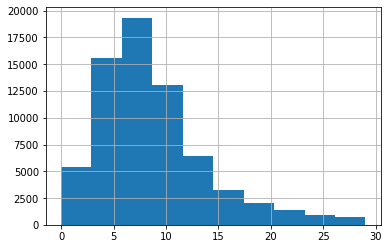

In [ ]:
reddit_memes_postes["word_count"][reddit_memes_postes["word_count"]<30].hist()

### Colors

"we extracted colors from the HSV versions of our meme images. We used an OpenCV image segmentation technique to isolate 30 colors, including a small range around the specific HSV value of the color. This range was used to mask the images, revealing only pixels within that color range. The number of pixels in the mask was normalized for images of differing sizes by dividing by the total number of pixels in the image. These color attributes represent the amount of each of the 30 given colors present in the meme images."

In [ ]:
#RGB and HSV base cordines plus the 30 base colors extracted using OpenCV
reddit_memes_postes[['avg_blueRGB', 'avg_greenRGB',
       'avg_hue', 'avg_redRGB', 'avg_saturation', 'avg_value', 'off-white',
       'aqua', 'mustard', 'pure-black', 'purple', 'red-brown', 'dust-brown',
       'gray-blue', 'orange', 'salmon', 'dark-green', 'pink', 'pure-white',
       'yellow-green', 'bright-yellow', 'teal', 'cyan', 'gray', 'maroon',
       'olive', 'light-blue', 'plum', 'siena-brown', 'gold', 'pure-red',
       'pure-green', 'pure-blue', 'coral', 'peach', 'col']].describe()

,avg_blueRGB,avg_greenRGB,avg_hue,avg_redRGB,avg_saturation,avg_value,off-white,aqua,mustard,pure-black,...,light-blue,plum,siena-brown,gold,pure-red,pure-green,pure-blue,coral,peach,col
count,50651.000000,50651.000000,50651.000000,50651.000000,50651.000000,50651.000000,50538.000000,50538.000000,50538.000000,50538.000000,...,50538.000000,50538.0,50538.0,50538.000000,50538.000000,50538.000000,50538.000000,50538.0,50538.000000,50538.000000
mean,128.639556,133.423249,46.300384,140.567151,65.437999,150.060820,4.798367,0.153165,0.167914,16.674078,...,0.094840,0.0,0.0,3.750098,0.055067,0.475572,0.109823,0.0,1.834024,2.522078
std,50.418799,49.587056,28.166636,49.936033,38.960155,48.927037,11.777363,2.312782,2.428924,35.540049,...,1.811116,0.0,0.0,9.429906,2.321886,4.390867,2.114918,0.0,7.295825,8.577559
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,93.589513,100.048523,24.389515,107.510989,37.174465,117.865021,0.463955,0.000000,0.000000,1.284356,...,0.000000,0.0,0.0,0.001864,0.000000,0.000000,0.000000,0.0,0.000000,0.003986
50%,126.528284,132.802437,42.309425,141.884962,60.765319,152.472961,1.573736,0.000000,0.000000,4.341714,...,0.000000,0.0,0.0,0.319410,0.000000,0.000000,0.000000,0.0,0.008263,0.201326
75%,162.083398,167.005624,64.330374,174.196552,89.668617,184.591979,4.369115,0.000000,0.000000,11.297761,...,0.000000,0.0,0.0,2.920194,0.000000,0.000000,0.000000,0.0,0.509722,1.466760
max,255.000000,255.000000,175.696601,255.000000,255.000000,255.000000,247.087264,171.017748,197.031814,255.000000,...,232.608481,0.0,0.0,171.191175,228.863858,223.208661,213.277334,0.0,207.360236,169.718836


Many of them are all zeros (colores that are not present in the memes in the dataset (ex: coral color).

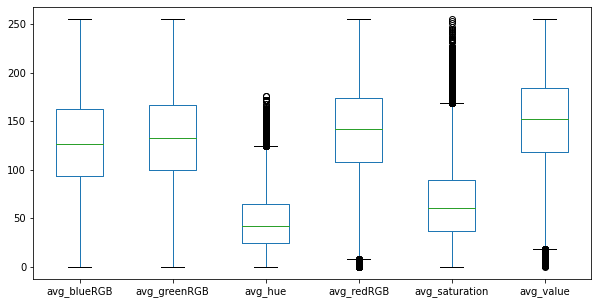

In [ ]:
reddit_memes_postes[['avg_blueRGB', 'avg_greenRGB', 'avg_hue', 'avg_redRGB', 'avg_saturation', 'avg_value']].plot.box(figsize=(10,5))

### vgg features

the results of applying a vgg16 pretrained neural network on the images to predict the objects on the image, where vgg_feature_X is the category X and vggX_prob it's probability of being correct.

In [ ]:
reddit_memes_postes['vgg_feature_1'].head()

0        binder
1    neck_brace
2      envelope
3      web_site
4      web_site
Name: vgg_feature_1, dtype: object

In [ ]:
all_categories_dup = np.concatenate([reddit_memes_postes['vgg_feature_1'][reddit_memes_postes['vgg_feature_1'].notnull()],
                                     reddit_memes_postes['vgg_feature_2'][reddit_memes_postes['vgg_feature_2'].notnull()],
                                     reddit_memes_postes['vgg_feature_3'][reddit_memes_postes['vgg_feature_3'].notnull()]])
print("we have", str(len(np.unique(all_categories_dup))), "unique categories")

we have 982 unique categories


<BarContainer object of 15 artists>

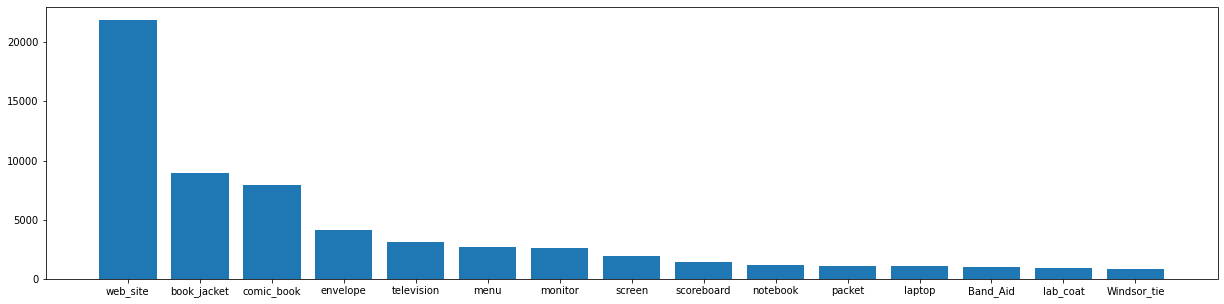

In [ ]:
from collections import Counter
b = Counter(all_categories_dup)

n = 15
keys = [element[0] for element in b.most_common(n)]
values = [element[1] for element in b.most_common(n)]

plt.figure(figsize=(21,5))
plt.bar(keys, values)

By far the term 'web_site' is the most requiring, the reason being that a high number of images were created by a website that keeps its watermark on the images and therefore was detected by the vgg neural network.

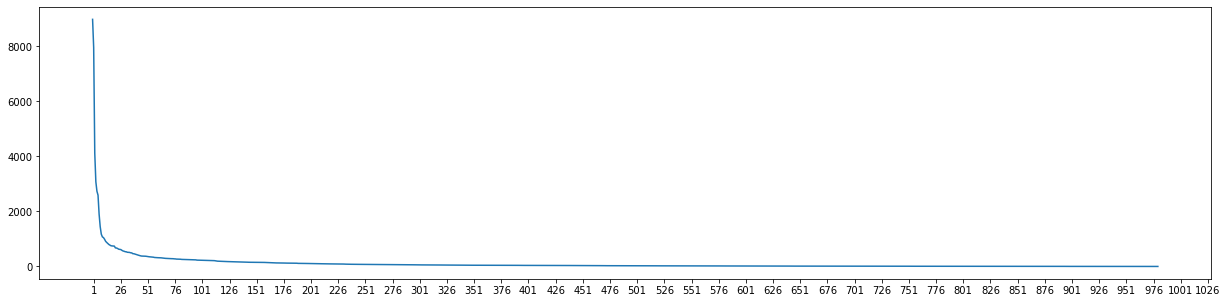

In [ ]:
from collections import Counter
b = Counter(all_categories_dup)

keys = [element[0] for element in b.most_common()][1:]
values = [element[1] for element in b.most_common()][1:]

plt.figure(figsize=(21,5))
plt.xticks(np.arange(min(values), max(values)+1, 25.0))
plt.plot(values)

Even after removing it the minority still rules.

## Dataset Insight
### Let's visualize the relationships between pairs of features by plotting the scatter plots of each pairs in the cartesian product of features

In [ ]:
%matplotlib inline
_ = pd.plotting.scatter_matrix(reddit_memes_postes, figsize=(70,70), marker='o',hist_kwds={'bins':20},s=60,alpha=.8)

#### Below we propose another visualization showing the distributions of feature values, as well as some scatter plots for specific pairs of features

<AxesSubplot:xlabel='thumbnail.width', ylabel='ups'>

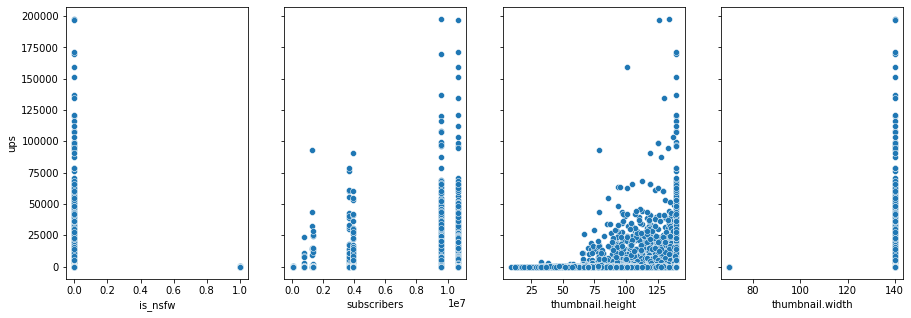

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
sns.scatterplot(ax=axes[0],x=reddit_memes_postes["is_nsfw"], y=reddit_memes_postes.ups)
sns.scatterplot(ax=axes[1],x=reddit_memes_postes["subscribers"], y=reddit_memes_postes.ups)
sns.scatterplot(ax=axes[2],x=reddit_memes_postes["thumbnail.height"], y=reddit_memes_postes.ups)
sns.scatterplot(ax=axes[3],x=reddit_memes_postes["thumbnail.width"], y=reddit_memes_postes.ups)

<AxesSubplot:xlabel='time_of_day', ylabel='ups'>

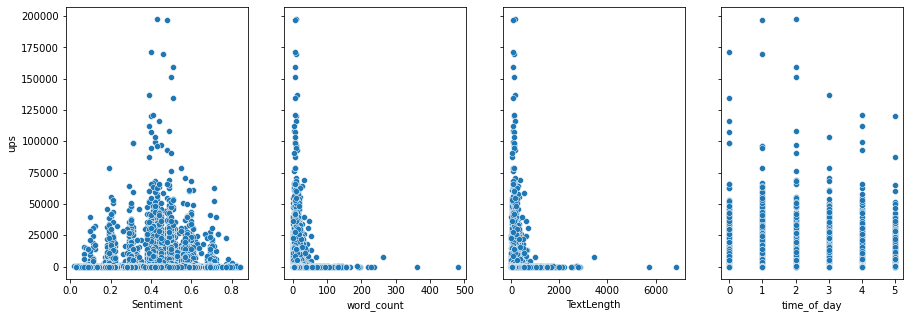

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
sns.scatterplot(ax=axes[0],x=reddit_memes_postes["Sentiment"], y=reddit_memes_postes.ups)
sns.scatterplot(ax=axes[1],x=reddit_memes_postes["word_count"], y=reddit_memes_postes.ups)
sns.scatterplot(ax=axes[2],x=reddit_memes_postes["TextLength"], y=reddit_memes_postes.ups)
sns.scatterplot(ax=axes[3],x=reddit_memes_postes["time_of_day"], y=reddit_memes_postes.ups)

<AxesSubplot:xlabel='vgg2_prob', ylabel='ups'>

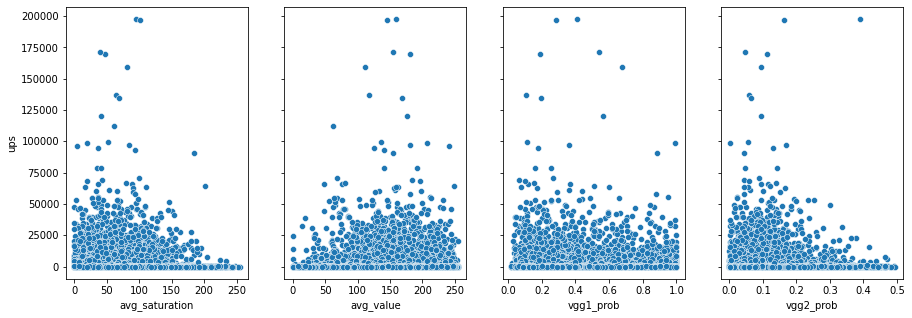

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
sns.scatterplot(ax=axes[0],x=reddit_memes_postes["avg_saturation"], y=reddit_memes_postes.ups)
sns.scatterplot(ax=axes[1],x=reddit_memes_postes["avg_value"], y=reddit_memes_postes.ups)
sns.scatterplot(ax=axes[2],x=reddit_memes_postes["vgg1_prob"], y=reddit_memes_postes.ups)
sns.scatterplot(ax=axes[3],x=reddit_memes_postes["vgg2_prob"], y=reddit_memes_postes.ups)


 With the results of correlation matrix , we can clearly choose our features and remove those with less correlation with our target value which it's "ups" (the up vote), after analyzing the different results , we are going to use as features entries {thumbnail.height, time_of_day,TextLength,Sentiment,avg_value, all the vgg mentioned, is_nsfw) the avg_value means whether the picture has higher brightness or not and we all know that when the picture is dark it hass less effect then the bright one (in the memes context) . We didnt choose the colors columns even if it has higher correlations , because it was used for an image processing purpose which was to predict Sentiment.

# **Define the Problem as a Machine learning Problem**

##  **The Problem** 



 Predicting popularity of posts in social media networks is an interesting task: could be used for more targeted advertising, content filtering , understanding population general opinion or just improving one's own reputation .
  We will focus on the topic of Memes from Reddit Plateform , the popular one with a lot of examples and data ready to use, with all of that we will try to predict their scores(number of upvotes).



###  Assumptions :

 
 For example in our work : 
 <ul>
  <li>the size of thumbnail in the meme used will matter to the model.
  <li> The number of subscribers in the subbredit does not matter to the model.
  <li>The type of color used on the image may matter to the model.
  <li>Older posts are less predictive than more recent ones. 
  </ul>

## **Motivation**


 This problem need to be solved since the community of "memers" is so huge and very active , we can clearly see a lot of new memes posted everyday in all types of subjects. And also we are solving this problem to make sure we assimiled all the machine learning methods that we studied up to now and see if we can get a good model as a result.
  Solving this problem might helps a lot of "memers", personnally I create a lot of memes but sometimes I hesitate to post them fearing that it will not get enough recognition or positive reacts so at the end I just keep them on my archive folder , and I'm pretty sure I'm not the only one facing this problem.


## **Solution Use**


  Solving this problem and generating the final model can be considered as easy to use for all types of users without having any background on machine learning or data science in general. But we are not sure this project will be working at a long period since methods are getting evoluating each day and even the approach and the vision of the memes community change every month or week , so this project is jsut beginning and can be set at a maintenance lifetime. It can also influence the reddit community , we pretend that by using this model the quality of memes will be increased and why not we can adopt the solution for different types of subredits.



## **How would we solve the problem?**


  This problem can be solved by first of all collecting the data , we are lucky that we found a complete dataset in "Dank_Meme_Article" that just need to be optimised and cleaned (preprocessing steps).
  Then , we will use diffrent Machine learning approach to get the suited model for our problem by comparing their scores, we will explain it deeply in the following chapter. 

# **Define the methodology and protocol that we will use to tackle the problem.** 

To tackle our problem we will use the standard workflow of a Machine Learning project.

## Gathering Data

We will use an existing dataset of reddit posts as mentioned in the second section. 

## Data pre-processing

## Researching the model that will be best for the type of data


Our main goal is to train the best performing model possible, using the pre-processed data.
By Projecting our case to SkLearn road map we have to chose these models :
<ul> 
<li>Ridge Regression</li>
<li>RandomForest</li>
<li>BayesianRidge</li>
</ul>

<img src="https://scikit-learn.org/stable/_static/ml_map.png" width=700px />

## Training and testing the model on data

For training a model we initially split the model into 3 three sections which are ‘Training data’ ,‘Validation data’ and ‘Testing data’.
We will train the classifier using ‘training data set’, tune the parameters using ‘validation set’ and then test the performance of your classifier on unseen ‘test data set’.

## Evaluate the Model

We will use the R-squared metric to "measure" objective performance of the model.
R-squared is a statistical measure of how close the data are to the fitted regression line. It is also known as the coefficient of determination, or the coefficient of multiple determination for multiple regression.

The definition of R-squared is fairly straight-forward; it is the percentage of the response variable variation that is explained by a linear model. Or:

R-squared = Explained variation / Total variation

R-squared is always between 0 and 100%:

0% indicates that the model explains none of the variability of the response data around its mean.
100% indicates that the model explains all the variability of the response data around its mean.
In general, the higher the R-squared, the better the model fits your data. 

## Parameter Tuning

- This step refers to hyperparameter tuning.

- Tune model parameters for improved performance.
- hyperparameter :

**Ridge**:

-- alpha: Regularization strength

--fit_intercept:Whether to fit the intercept for this model

--solver: Solver to use in the computational routines

--degree : The degree of the polynomial features.
	
**Bayesian**: 

--n_iter : Maximum number of iterations

--alpha_1:  shape parameter for the Gamma distribution prior over the alpha parameter.

--alpha_2: inverse scale parameter (rate parameter) for the Gamma distribution prior over the alpha parameter.

--lambda_1:shape parameter for the Gamma distribution prior over the lambda parameter.
	
--lambda_2:  inverse scale parameter (rate parameter) for the Gamma distribution prior over the lambda parameter.
	
**RandomForest**:

--n_estimators : The number of trees in the forest.
	
--max_depth : The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
	
--min_samples_split :  The minimum number of samples required to split an internal node
	
--min_samples_leaf : The minimum number of samples required to be at a leaf node.
	
--max_features : The number of features to consider when looking for the best split:
	
--bootstrap : Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.


# **Implementing various approaches**

## Data Pre-processing

### Cleaning

In [ ]:
columns_to_drop = ['awards', 'processed_words', 'created_utc','thumbnail.width', 'subscribers', 'title', 'url',
                   'datetime_temp','ups_normed', 'dank_level','word_count', 'avg_blueRGB', 'avg_greenRGB',
                   'avg_hue', 'avg_redRGB', 'avg_saturation','off-white', 'aqua', 'mustard', 'pure-black','pink',
                   'purple', 'red-brown', 'dust-brown', 'gray-blue', 'orange', 'salmon', 'dark-green', 'pure-white',
                   'yellow-green', 'bright-yellow', 'teal', 'cyan', 'gray', 'maroon', 'olive', 'light-blue',
                   'plum', 'siena-brown', 'gold', 'pure-red', 'pure-green', 'pure-blue', 'coral', 'peach', 'col']
reddit_memes_postes.drop(columns=columns_to_drop,inplace=True)
print(reddit_memes_postes.columns)

Index(['Unnamed: 0', 'level_0', 'index', 'author', 'downs', 'id', 'is_nsfw',
       'media', 'subreddit', 'thumbnail.height', 'thumbnail.thumbnail', 'ups',
       'time_of_day', 'TextLength', 'Sentiment', 'avg_value', 'vgg1_prob',
       'vgg2_prob', 'vgg3_prob', 'vgg_feature_1', 'vgg_feature_2',
       'vgg_feature_3'],
      dtype='object')


### Selecting the subreddit

let start with the subreddit with the heigher number of posts

In [ ]:
reddit_memes_postes.dropna(inplace=True)

In [ ]:
reddit_memes_postes_original = reddit_memes_postes.copy()

In [ ]:
reddit_memes_postes = reddit_memes_postes[reddit_memes_postes["subreddit"] == reddit_memes_postes["subreddit"].value_counts().idxmax()]
reddit_memes_postes.drop(columns=["subreddit"],inplace=True)

### Encoding vgg features

To be able to work with the vgg features and their probabilities we encode them in a single vector before being added to the dataframe.

In [ ]:
def vgg_transformer(reddit_memes_postes):
  def catg_prob_to_vector(all_categories, categories, probabilities):
    result = np.zeros(len(all_categories))
    for i, categorie_element in enumerate(all_categories):
      for j, categorie in enumerate(categories):
        if categorie==categorie_element:
          result[i] = probabilities[j]
    return result

  all_categories_dup = np.concatenate([reddit_memes_postes['vgg_feature_1'][reddit_memes_postes['vgg_feature_1'].notnull()],
                                       reddit_memes_postes['vgg_feature_2'][reddit_memes_postes['vgg_feature_2'].notnull()],
                                       reddit_memes_postes['vgg_feature_3'][reddit_memes_postes['vgg_feature_3'].notnull()]])
  all_categories = np.unique(all_categories_dup)
  new_vgg = []
  for _,row in reddit_memes_postes.iterrows():
    temp_c = np.concatenate([[row['vgg_feature_1']],
                            [row['vgg_feature_2']],
                            [row['vgg_feature_3']]])
    temp_p = np.concatenate([[row['vgg1_prob']],
                            [row['vgg2_prob']],
                            [row['vgg3_prob']]])
    new_vgg.append(catg_prob_to_vector(all_categories, temp_c, temp_p))
  return new_vgg

In [ ]:
new_vgg = vgg_transformer(reddit_memes_postes)

### Dimension reduction of vgg features

As you can see the size of the vector is high therfore we propose deducing the dimension of the vector using pca:

In [ ]:
def plot_variance_nbComponents(vectors, percentage_variance, figsize=(15, 5)):
  pca = PCA().fit(vectors)
  fig = plt.figure(figsize=figsize)
  plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
  plt.axhline(y=percentage_variance, color="red")
  plt.xlabel('No. of principal components')
  plt.ylabel('cumulative % variance retained')
  plt.grid(True)
  plt.title('Cumulative explained variance across the number of components of vgg') 

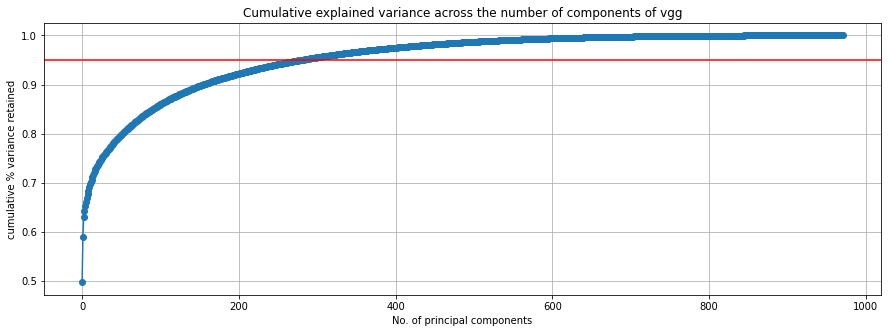

In [ ]:
plot_variance_nbComponents(new_vgg, 0.95)

In [ ]:
pca = PCA(n_components=50)
new_vgg = pca.fit_transform(new_vgg)

Now we can add it:

In [ ]:
temporal_df = pd.DataFrame(new_vgg,columns=[str(value) for value in range(len(new_vgg[0]))])

In [ ]:
reddit_memes_postes.reset_index(drop=True, inplace=True)
temporal_df.reset_index(drop=True, inplace=True)
reddit_memes_postes = pd.concat([reddit_memes_postes, temporal_df], axis=1)

### Designing Pipeline for pre-processing

In [ ]:
X = reddit_memes_postes.drop(columns=["ups"],axis=1) # remove the column we want to predict
y = reddit_memes_postes["ups"] 

#Define Numerical features
numeric_features = ['TextLength', 'Sentiment', 'avg_value','thumbnail.height'] + [str(value) for value in range(len(new_vgg[0]))]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])

#Define Categorical features 
categorical_features = ["is_nsfw", "time_of_day"] # data that we want to convert to numerical

categorical_transformer = Pipeline(steps=[
      ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

# Setup preprocessing  steps (Converting categorical features to numerical)
preprocessor = ColumnTransformer(transformers=[
                                    ('num', numeric_transformer, numeric_features),
                                    ("cat",categorical_transformer,categorical_features)                                              
                                 ])

### Spliting data

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

## Training Models

### Linear Regression:


we choose Linear Regression because it the first model we learned.

In [ ]:
linear_regression_model = Pipeline(steps=[
                                          ("preprocessor",preprocessor),
                                          ("model",LinearRegression())                    
                          ])    

linear_regression_model.fit(X_train,y_train)

print(f"R-squared Training score on Linear Regression:{round(linear_regression_model.score(X_train,y_train),8)}")

R-squared Training score on Linear Regression:0.0038428


as you can see the performance of linear regression is too poor so we chose to add some Polynomial features to try to getting a higher performance and adding regularization with Ridge Model

In [ ]:
ridge_regression_model = Pipeline(steps=[("preprocessor",preprocessor),
                                         ("poly",PolynomialFeatures(degree=2)),
                                         ("model",Ridge(alpha=0.4))                    
                        ])    

ridge_regression_model.fit(X_train,y_train)

print(f"R-squared Training score on linear Regression with polynomial features and regularization:{round(ridge_regression_model.score(X_train,y_train),8)}")

R-squared Training score on linear Regression with polynomial features and regularization:0.05112017


### BayesianRidge Model


We chose Bayesian ridge model since it's a classical regularization technique widely used in Statistics and Machine Learning that we hope will impove the score of the previous model.

In [ ]:
bayesian_ridge_model = Pipeline(steps=[("preprocessor",preprocessor),
                        ("model",BayesianRidge())                    
                        ])    

bayesian_ridge_model.fit(X_train,y_train)

print(f"R-squared Training score on Bayesian Regression: {round(bayesian_ridge_model.score(X_train,y_train),8)}")

R-squared Training score on Bayesian Regression: 0.00161699


### Random Forest Regressor

Well this is not going well, let's try a differente kind of models

In [ ]:
random_forest_regressor = Pipeline(steps=[("preprocessor",preprocessor),
                        ("model",RandomForestRegressor())                    
                        ])    

random_forest_regressor.fit(X_train,y_train)

print(f"R-squared Training score on Random forest regressor:{round(random_forest_regressor.score(X_train,y_train),8)}")

R-squared Training score on Random forest regressor:0.84911876


## Evaluating and tuning hyperparameter 

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [ ]:
# define search space
#for Ridge
params_Ridge = {"model__alpha": [1,0.1,0.01,0.001,0.0001,0] , 
                "model__fit_intercept": [True, False], 
                "model__solver": ['svd', 'cholesky'],
                "poly__degree" : [2,5,10]
                }
#for BayesianRidge
params_Bayesian_Ridge = {"model__n_iter": [200, 400, 500], 
                "model__alpha_1": [1e-6, 1e-4,3e-2],
                "model__alpha_2": [1e-6, 1e-4,3e-2],  
                "model__lambda_1": [1e-6, 1e-4,3e-2]
                }
#for RandomForest 
#a reproduire a la main
params_Random_Forest = {
              'model__max_depth': [None, 10, 20, 60],
              'model__bootstrap': [True, False],
              'model__max_features': ['auto', 'sqrt'],
              'model__min_samples_leaf': [1, 2, 4],
              'model__min_samples_split': [2, 5, 10],
              'model__n_estimators': [10,100,400,1000,2000,2e+6]
    }

Considering that we don't have enough ressources, we will do the search on a subset of the one defined above.

In [ ]:
#for Ridge
params_Ridge = {
    "model__alpha": [0.1, 0.4], 
    "model__fit_intercept": [True, False], 
    #"model__solver": ['svd', 'cholesky'],
    }
#for BayesianRidge
params_Bayesian_Ridge = {
    "model__n_iter": [200, 400],
    "model__alpha_1": [1e-6, 1e-4],
    "model__alpha_2": [1e-6, 1e-4]
    }
#for RandomForest
params_Random_Forest = {
    "model__n_estimators" : [10,15],
    "model__max_depth": [None, 10],
    "model__min_samples_split": [2, 5],
    }

In [ ]:
models = [ridge_regression_model,bayesian_ridge_model, random_forest_regressor]
parametres = [params_Ridge,params_Bayesian_Ridge,params_Random_Forest]

for param,model in zip(parametres,models):
  search = GridSearchCV(estimator = model, param_grid=param, scoring='r2', n_jobs=-1, cv=cv)
  print(model.named_steps["model"].__class__.__name__)
  result = search.fit(X_train,y_train)
  print(f"Best Score: %s" % result.best_score_)
  print(f"Best Hyperparameters: %s" % result.best_params_)

Ridge
Best Score: -0.4445301668453781
Best Hyperparameters: {'model__alpha': 0.4, 'model__fit_intercept': True}
BayesianRidge
Best Score: 7.610802460895257e-05
Best Hyperparameters: {'model__alpha_1': 0.0001, 'model__alpha_2': 1e-06, 'model__n_iter': 200}
RandomForestRegressor
Best Score: -0.09751693021081076
Best Hyperparameters: {'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 15}


## Results discussion

As you can see the performance of our choosen models is very poor which is due to not having hight enough corelation between the features on the dataset and our target which affirms our intuition that the score depend principally on the originality of the meme and the context it was posted on.

We have the following propositions to improve the performance:
* Adding well distrubuted data (in our dataset the majority was on the first quartile).
* Searching for new features that have high correlation with the target (accounting for the history of the meme, ot's context, from where it originated...)

# Our best model

Based on the output of the grid search we conclude that the Bayesian ridge model is the optimal model that we can get to solve our task.

In [ ]:
bayesian_ridge_model = Pipeline(steps=[("preprocessor",preprocessor),
                        ("model",BayesianRidge(alpha_1=0.0001, alpha_2=1e-06, n_iter=200))                    
                        ]) 
model = bayesian_ridge_model

In [ ]:
model.fit(X_train,y_train)
predictions = model.predict(X_test)

errors = abs(predictions - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 995.68


# Knowledge Transfer (Bonus)

In [ ]:
for subreddit in reddit_memes_postes_original["subreddit"].unique():
  if subreddit == 'r/memes': continue
  current_subreddit = reddit_memes_postes_original[reddit_memes_postes_original["subreddit"] == subreddit]
  current_subreddit.drop(columns=["subreddit"],inplace=True)

  new_vgg = vgg_transformer(current_subreddit)

  pca = PCA(n_components=50)
  new_vgg = pca.fit_transform(new_vgg)
  temporal_df = pd.DataFrame(new_vgg,columns=[str(value) for value in range(len(new_vgg[0]))])
  current_subreddit.reset_index(drop=True, inplace=True)
  temporal_df.reset_index(drop=True, inplace=True)
  current_subreddit = pd.concat([current_subreddit, temporal_df], axis=1)

  X = current_subreddit.drop(columns=["ups"],axis=1)
  y = current_subreddit["ups"] 

  print(subreddit,":")
  print(f"R-squared score: {round(model.score(X, y),8)}")
  predictions = model.predict(X)
  errors = abs(predictions - y)
  print('Mean Absolute Error:', round(np.mean(errors), 2))
  print()

r/dank_meme :
R-squared score: -0.37031891
Mean Absolute Error: 622.26

r/dankmeme :
R-squared score: -25.68981096
Mean Absolute Error: 525.26

r/me_irl :
R-squared score: -0.00011053
Mean Absolute Error: 880.52

r/MemeEconomy :
R-squared score: -0.06057316
Mean Absolute Error: 683.68



# References:

* https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
* Barnes, Kate, et al. "Dank or Not?--Analyzing and Predicting the Popularity of Memes on Reddit." arXiv preprint arXiv:2011.14326 (2020).
* https://en.wikipedia.org/
* https://stackoverflow.com/